In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Importing Libraries

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
import lightgbm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Activation,Embedding,LSTM,Concatenate,Flatten,Dropout,Bidirectional
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam,SGD
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks,Sequential
from statsmodels.tsa.arima_model import ARIMA,ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from datetime import datetime
from prettytable import PrettyTable
from tensorflow.keras import backend as K
import shutil,os
import pickle

## Reading data

In [2]:
#pjm_data  = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/pjm_mw_data.pkl')
pjm_data  = pd.read_pickle('pjm_data.pkl')
pjm_data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


## New Data Preparation

The given time series data is univariate.In modelling part-1 we first did feature engineering and came up with new features and then after doing feature selection we selected top features which retained 99% information of data and did did Supervised algorithmn modellinh and deep learning modelling like LSTM and BidirectionalLSTM.<br>
Now what will we do is we take original univaraite time series data but this time we will not do feature engineering but will still make data supervised so that we can use supervised alagorithm and deep learning model.<br>
The idea is as follows:<br>
Consider the univariate series as follows : [1,2,3,4,5,6,7,8,9,10]
<br>
We can divide the univariate time series into multiple input/output patterns called samples, where four time steps are used as independent variables/input and one time step is used as traget variable/output for the one-step prediction that is being learned.<br>

independent_var_1 | independent_var_1 | independent_var_1 | independent_var_1 | target_var |
:---: | :---: | :---: | :---: | :---: |
1 | 2 | 3 | 4 | 5 |
2 | 3 | 4 | 5 | 6 |
3 | 4 | 5 | 6 | 7 |
4 | 5 | 6 | 7 | 8 |
5 | 6 | 7 | 8 | 9 |
6 | 7 | 8 | 9 | 10 |

In [3]:
#pjm_df = pjm_data['PJME_MW']
pjm_df = pjm_data.copy()
#pjm_df.index = pjm_df['Datetime']
del pjm_df['Datetime']
pjm_df = pjm_df.sort_index()
pjm_df.head(3)


,PJME_MW
0,26498.0
1,25147.0
2,24574.0


### Log transformation of data to make it stationary

In [4]:
pjm_df['PJME_MW'] = np.log1p(pjm_df['PJME_MW'])
pjm_df.head()

,PJME_MW
0,10.184862
1,10.132534
2,10.109485
3,10.102092
4,10.121056


In [5]:
pjm_df = pjm_df.values
print('The shape of the data : ',pjm_df.shape)
print('Type of data : ',type(pjm_df))

The shape of the data :  (145362, 1)
Type of data :  <class 'numpy.ndarray'>


In [6]:
def construct_supervised_data(data,time_steps):
    independent_var = []
    dependent_var = []
    for i in range(len(data)):
        x = i + time_steps
        if x >= len(data) - 1:
            break
        independent_x = data[i : x]
        dependent_y = data[x]
        independent_var.append(independent_x)
        dependent_var.append(dependent_y)
    return np.array(independent_var), np.array(dependent_var)
    


In [7]:
X,y = construct_supervised_data(pjm_df,4)
X = X.reshape(145357, 4*1)
print('Shape of X : ',X.shape)
print('Shape of y : ',y.shape)

Shape of X :  (145357, 4)
Shape of y :  (145357, 1)


In [ ]:
for i in range(len(X)):
    print(X[i], y[i])


Streaming output truncated to the last 5000 lines.
[10.4630462  10.51934864 10.56382741 10.59808368] [10.62871463]
[10.51934864 10.56382741 10.59808368 10.62871463] [10.6475417]
[10.56382741 10.59808368 10.62871463 10.6475417 ] [10.66038388]
[10.59808368 10.62871463 10.6475417  10.66038388] [10.66513415]
[10.62871463 10.6475417  10.66038388 10.66513415] [10.64958291]
[10.6475417  10.66038388 10.66513415 10.64958291] [10.60903256]
[10.66038388 10.66513415 10.64958291 10.60903256] [10.56797802]
[10.66513415 10.64958291 10.60903256 10.56797802] [10.52878407]
[10.64958291 10.60903256 10.56797802 10.52878407] [10.45414908]
[10.60903256 10.56797802 10.52878407 10.45414908] [10.37164573]
[10.56797802 10.52878407 10.45414908 10.37164573] [10.39815331]
[10.52878407 10.45414908 10.37164573 10.39815331] [10.33439296]
[10.45414908 10.37164573 10.39815331 10.33439296] [10.28465997]
[10.37164573 10.39815331 10.33439296 10.28465997] [10.25495396]
[10.39815331 10.33439296 10.28465997 10.25495396] [10.

## Splitting the data into train and test

In [8]:
def performance_metrics(y_actual,y_predict):
    y_actual = np.expm1(np.array(y_actual))[-100:]
    y_predict = np.expm1(np.array(y_predict))[-100:]
    mape = np.mean(np.abs((y_actual-y_predict)/y_actual))*100
    mae = mean_absolute_error(y_actual,y_predict)
    mse = mean_squared_error(y_actual,y_predict)
    rmse = sqrt(mean_squared_error(y_actual,y_predict))
    return rmse,mae,mape,mse

In [9]:
def result_visualization(y,y_hat,title=None):
    y = np.expm1(np.array(y))[-100:]
    y_hat = np.expm1(np.array(y_hat))[-100:]
    plt.figure(figsize=(23,5))
    plt.plot(y,label='true')
    plt.plot(y_hat,label='predicted')
    #plt.xlim(dt(2016, 1, 1),dt(2018, 12, 31))
    plt.legend()
    plt.grid()
    plt.title(title)
    
    plt.show()

## Machine Learning Modelling with Hyperparameter Tuning

In [10]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
size = 100
X_train = X[:-size]
X_test = X[-size:]
y_train = y[:-size]
y_test = y[-size:]
print('Shape of X_train : ',X_train.shape)
print('Shape of y_train : ',y_train.shape)
print('Shape of X_test : ',X_test.shape)
print('Shape of y_test : ',y_test.shape)

Shape of X_train :  (145257, 4)
Shape of y_train :  (145257, 1)
Shape of X_test :  (100, 4)
Shape of y_test :  (100, 1)


### Dummy Regressor

In [ ]:
%%time
dummy_model = DummyRegressor(strategy="quantile",quantile=0.92)
dummy_model.fit(X_train, y_train)
dummy_model_predict = dummy_model.predict(X_test)

Wall time: 3.99 ms


RSME : 3322.8877046479697
MAE : 2808.9815997607975
MAPE : 6.990669496344992
MSE : 11041582.697700653


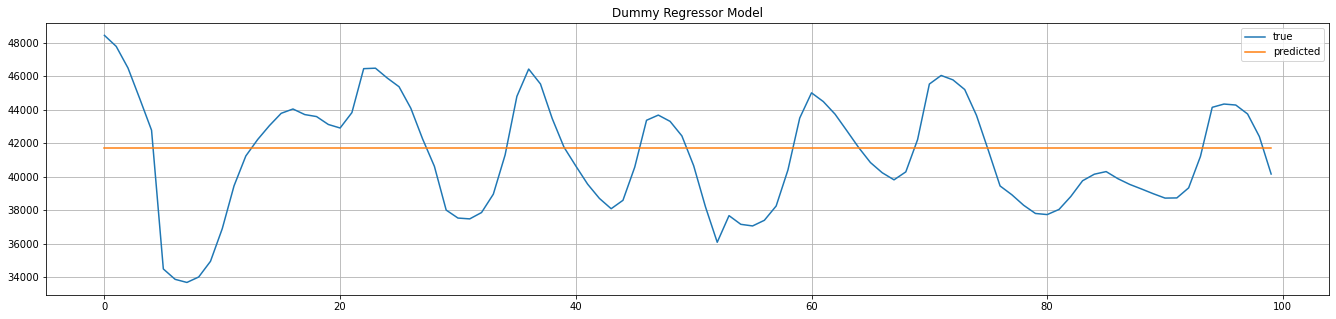

In [ ]:
rmse_dummy,mae_dummy,mape_dummy,mse_dummy = performance_metrics(y_test,dummy_model_predict)
print('RSME :',rmse_dummy)
print('MAE :',mae_dummy)
print('MAPE :',mape_dummy)
print('MSE :',mse_dummy)

result_visualization(y_test,dummy_model_predict,title='Dummy Regressor Model')

### SGD Linear Regression

In [ ]:
%%time

parameters = {'alpha':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100],
             'max_iter':[100,300,500,1000,2000],
             'penalty':['l1','l2','elasticnet'],
             'loss':['squared_epsilon_insensitive','squared_loss','huber','epsilon_insensitive']}

lin_reg = GridSearchCV(SGDRegressor(),param_grid = parameters,scoring='neg_mean_absolute_percentage_error', verbose=1,
                   n_jobs=-1, cv=3)
lin_reg.fit(X_train,y_train)
print("best parameters found was :",lin_reg.best_params_)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
best parameters found was : {'alpha': 1e-05, 'loss': 'epsilon_insensitive', 'max_iter': 300, 'penalty': 'l2'}
Wall time: 30min 59s


In [22]:
%%time
sgd_lin_reg = SGDRegressor(loss='epsilon_insensitive',alpha=1e-05,penalty='l2',shuffle=True,
                           tol=0.000001,l1_ratio=0.15,epsilon=0.01,learning_rate='adaptive',max_iter=300,eta0 =0.01)
sgd_lin_reg.fit(X_train,y_train)
sgd_lin_prediction = sgd_lin_reg.predict(X_test)

Wall time: 2.96 s


RSME : 1291.9250070811368
MAE : 872.9747842324628
MAPE : 9.502240911488638
MSE : 1669070.2239215951


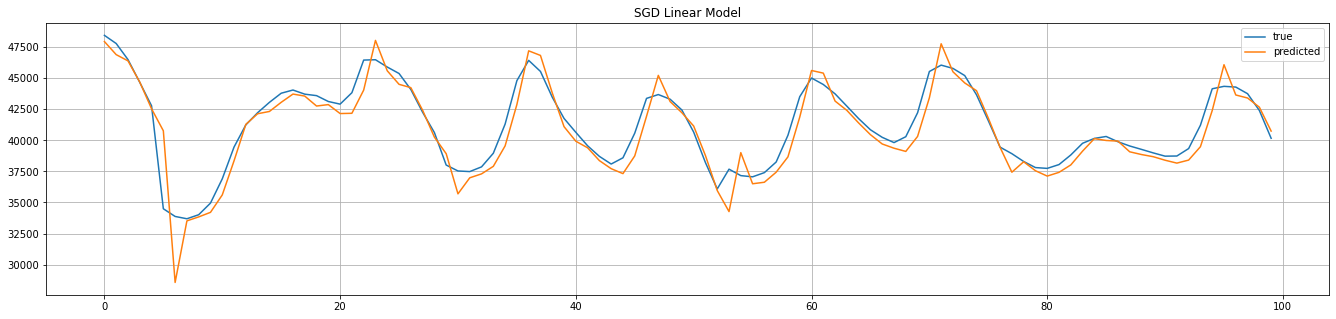

In [23]:
rmse_sgd,mae_sgd,mape_sgd,mse_sgd = performance_metrics(y_test,sgd_lin_prediction)
print('RSME :',rmse_sgd)
print('MAE :',mae_sgd)
print('MAPE :',mape_sgd)
print('MSE :',mse_sgd)

result_visualization(y_test,sgd_lin_prediction,title='SGD Linear Model')

### LightGBM

In [ ]:
%%time

parameters = {"n_estimators":[10,50,250,500,750,1000,1250,1500],
             "max_depth":[2,3,4,5],
             "learning_rate":[0.1,0.01,0.001]}

reg = GridSearchCV(lightgbm.LGBMRegressor(),param_grid = parameters,scoring='neg_mean_absolute_percentage_error', verbose=1,
                   n_jobs=-1, cv=3)

reg.fit(X_train,y_train)
print("best parameters found was :",reg.best_params_)


Fitting 3 folds for each of 96 candidates, totalling 288 fits
best parameters found was : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1500}
Wall time: 5h 27min 7s


In [34]:
%%time
lgbm_reg = lightgbm.LGBMRegressor(n_estimators=1000,max_depth=5,learning_rate =0.1,n_jobs=-1)
                                
lgbm_reg.fit(X_train,y_train)
lgbm_prediction = lgbm_reg.predict(X_test)

Wall time: 3.43 s


RSME : 1303.9959064975287
MAE : 848.4558971672968
MAPE : 9.747856440041591
MSE : 1700405.3241623116


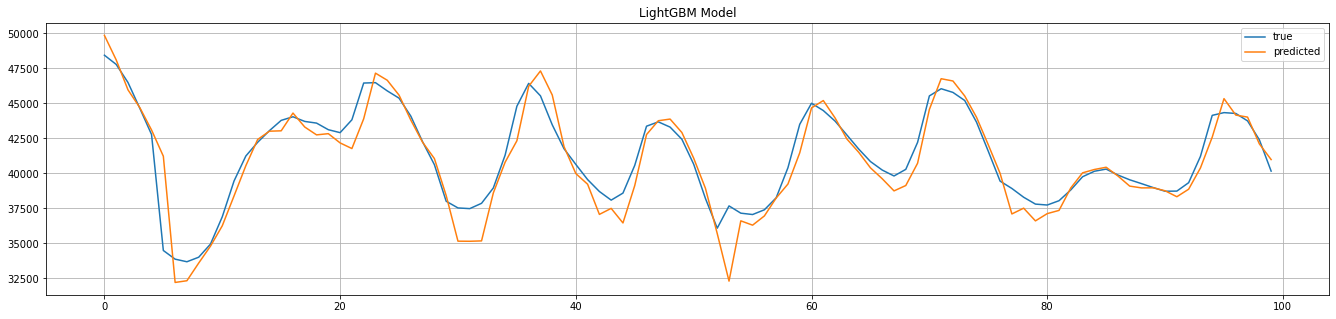

In [35]:
rmse_lgbm,mae_lgbm,mape_lgbm,mse_lgbm = performance_metrics(y_test,lgbm_prediction)
print('RSME :',rmse_lgbm)
print('MAE :',mae_lgbm)
print('MAPE :',mape_lgbm)
print('MSE :',mse_lgbm)

result_visualization(y_test,lgbm_prediction,title='LightGBM Model')

### Random Forest

In [ ]:
%%time

parameters = {"n_estimators":[100,250,500,750,1000,1250],
             "max_depth":[3,5,10,50],
             "max_features":['auto','sqrt','log2']}

rf_reg = GridSearchCV(RandomForestRegressor(),param_grid = parameters,scoring = 'neg_mean_absolute_percentage_error',
                     verbose=1,n_jobs=-1,cv=3)
rf_reg.fit(X_train,y_train)
print("best parameters found was :",rf_reg.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
best parameters found was : {'max_depth': 50, 'max_features': 'log2', 'n_estimators': 1250}
Wall time: 4h 36min 39s


In [38]:
%%time
random_fst_model = RandomForestRegressor(n_estimators=1250,n_jobs=-1,bootstrap=True,max_depth=50,max_features='log2',
                           verbose=5,random_state=1)
random_fst_model.fit(X_train,y_train)
random_fst_prediction = random_fst_model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1250
building tree 2 of 1250
building tree 3 of 1250
building tree 4 of 1250
building tree 5 of 1250
building tree 6 of 1250
building tree 7 of 1250
building tree 8 of 1250
building tree 9 of 1250
building tree 10 of 1250
building tree 11 of 1250
building tree 12 of 1250
building tree 13 of 1250
building tree 14 of 1250
building tree 15 of 1250
building tree 16 of 1250


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s


building tree 17 of 1250
building tree 18 of 1250
building tree 19 of 1250
building tree 20 of 1250
building tree 21 of 1250
building tree 22 of 1250
building tree 23 of 1250
building tree 24 of 1250
building tree 25 of 1250
building tree 26 of 1250
building tree 27 of 1250
building tree 28 of 1250
building tree 29 of 1250
building tree 30 of 1250
building tree 31 of 1250
building tree 32 of 1250
building tree 33 of 1250
building tree 34 of 1250
building tree 35 of 1250
building tree 36 of 1250
building tree 37 of 1250
building tree 38 of 1250
building tree 39 of 1250
building tree 40 of 1250
building tree 41 of 1250
building tree 42 of 1250
building tree 43 of 1250
building tree 44 of 1250
building tree 45 of 1250
building tree 46 of 1250
building tree 47 of 1250
building tree 48 of 1250
building tree 49 of 1250
building tree 50 of 1250
building tree 51 of 1250
building tree 52 of 1250
building tree 53 of 1250
building tree 54 of 1250
building tree 55 of 1250
building tree 56 of 1250


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.4s


building tree 68 of 1250
building tree 69 of 1250
building tree 70 of 1250
building tree 71 of 1250
building tree 72 of 1250
building tree 73 of 1250
building tree 74 of 1250
building tree 75 of 1250
building tree 76 of 1250
building tree 77 of 1250
building tree 78 of 1250
building tree 79 of 1250
building tree 80 of 1250
building tree 81 of 1250
building tree 82 of 1250
building tree 83 of 1250
building tree 84 of 1250
building tree 85 of 1250
building tree 86 of 1250
building tree 87 of 1250
building tree 88 of 1250
building tree 89 of 1250
building tree 90 of 1250
building tree 91 of 1250
building tree 92 of 1250
building tree 93 of 1250
building tree 94 of 1250
building tree 95 of 1250
building tree 96 of 1250
building tree 97 of 1250
building tree 98 of 1250
building tree 99 of 1250
building tree 100 of 1250
building tree 101 of 1250
building tree 102 of 1250
building tree 103 of 1250
building tree 104 of 1250
building tree 105 of 1250
building tree 106 of 1250
building tree 107 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.5s


building tree 159 of 1250
building tree 160 of 1250
building tree 161 of 1250
building tree 162 of 1250
building tree 163 of 1250
building tree 164 of 1250
building tree 165 of 1250
building tree 166 of 1250
building tree 167 of 1250
building tree 168 of 1250
building tree 169 of 1250
building tree 170 of 1250
building tree 171 of 1250
building tree 172 of 1250
building tree 173 of 1250
building tree 174 of 1250
building tree 175 of 1250
building tree 176 of 1250
building tree 177 of 1250
building tree 178 of 1250
building tree 179 of 1250
building tree 180 of 1250
building tree 181 of 1250
building tree 182 of 1250
building tree 183 of 1250
building tree 184 of 1250
building tree 185 of 1250
building tree 186 of 1250
building tree 187 of 1250
building tree 188 of 1250
building tree 189 of 1250
building tree 190 of 1250
building tree 191 of 1250
building tree 192 of 1250
building tree 193 of 1250
building tree 194 of 1250
building tree 195 of 1250
building tree 196 of 1250
building tre

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   53.3s


building tree 285 of 1250
building tree 286 of 1250
building tree 287 of 1250
building tree 288 of 1250
building tree 289 of 1250
building tree 290 of 1250
building tree 291 of 1250
building tree 292 of 1250
building tree 293 of 1250
building tree 294 of 1250
building tree 295 of 1250
building tree 296 of 1250
building tree 297 of 1250
building tree 298 of 1250
building tree 299 of 1250
building tree 300 of 1250
building tree 301 of 1250
building tree 302 of 1250
building tree 303 of 1250
building tree 304 of 1250
building tree 305 of 1250
building tree 306 of 1250
building tree 307 of 1250
building tree 308 of 1250
building tree 309 of 1250
building tree 310 of 1250
building tree 311 of 1250
building tree 312 of 1250
building tree 313 of 1250
building tree 314 of 1250
building tree 315 of 1250
building tree 316 of 1250
building tree 317 of 1250
building tree 318 of 1250
building tree 319 of 1250
building tree 320 of 1250
building tree 321 of 1250
building tree 322 of 1250
building tre

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min


building tree 448 of 1250
building tree 449 of 1250
building tree 450 of 1250
building tree 451 of 1250
building tree 452 of 1250
building tree 453 of 1250
building tree 454 of 1250
building tree 455 of 1250
building tree 456 of 1250
building tree 457 of 1250
building tree 458 of 1250
building tree 459 of 1250
building tree 460 of 1250
building tree 461 of 1250
building tree 462 of 1250
building tree 463 of 1250
building tree 464 of 1250
building tree 465 of 1250
building tree 466 of 1250
building tree 467 of 1250
building tree 468 of 1250
building tree 469 of 1250
building tree 470 of 1250
building tree 471 of 1250
building tree 472 of 1250
building tree 473 of 1250
building tree 474 of 1250
building tree 475 of 1250
building tree 476 of 1250
building tree 477 of 1250
building tree 478 of 1250
building tree 479 of 1250
building tree 480 of 1250
building tree 481 of 1250
building tree 482 of 1250
building tree 483 of 1250
building tree 484 of 1250
building tree 485 of 1250
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.1min


building tree 645 of 1250
building tree 646 of 1250
building tree 647 of 1250
building tree 648 of 1250
building tree 649 of 1250
building tree 650 of 1250
building tree 651 of 1250
building tree 652 of 1250
building tree 653 of 1250
building tree 654 of 1250
building tree 655 of 1250
building tree 656 of 1250
building tree 657 of 1250
building tree 658 of 1250
building tree 659 of 1250
building tree 660 of 1250
building tree 661 of 1250
building tree 662 of 1250
building tree 663 of 1250
building tree 664 of 1250
building tree 665 of 1250
building tree 666 of 1250
building tree 667 of 1250
building tree 668 of 1250
building tree 669 of 1250
building tree 670 of 1250
building tree 671 of 1250
building tree 672 of 1250
building tree 673 of 1250
building tree 674 of 1250
building tree 675 of 1250
building tree 676 of 1250
building tree 677 of 1250
building tree 678 of 1250
building tree 679 of 1250
building tree 680 of 1250
building tree 681 of 1250
building tree 682 of 1250
building tre

[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  3.0min


building tree 878 of 1250
building tree 879 of 1250
building tree 880 of 1250
building tree 881 of 1250
building tree 882 of 1250
building tree 883 of 1250
building tree 884 of 1250
building tree 885 of 1250
building tree 886 of 1250
building tree 887 of 1250
building tree 888 of 1250
building tree 889 of 1250
building tree 890 of 1250
building tree 891 of 1250
building tree 892 of 1250
building tree 893 of 1250
building tree 894 of 1250
building tree 895 of 1250
building tree 896 of 1250
building tree 897 of 1250
building tree 898 of 1250
building tree 899 of 1250
building tree 900 of 1250
building tree 901 of 1250
building tree 902 of 1250
building tree 903 of 1250
building tree 904 of 1250
building tree 905 of 1250
building tree 906 of 1250
building tree 907 of 1250
building tree 908 of 1250
building tree 909 of 1250
building tree 910 of 1250
building tree 911 of 1250
building tree 912 of 1250
building tree 913 of 1250
building tree 914 of 1250
building tree 915 of 1250
building tre

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  4.7min


building tree 1148 of 1250
building tree 1149 of 1250
building tree 1150 of 1250
building tree 1151 of 1250
building tree 1152 of 1250
building tree 1153 of 1250
building tree 1154 of 1250
building tree 1155 of 1250
building tree 1156 of 1250
building tree 1157 of 1250
building tree 1158 of 1250
building tree 1159 of 1250
building tree 1160 of 1250
building tree 1161 of 1250
building tree 1162 of 1250
building tree 1163 of 1250
building tree 1164 of 1250
building tree 1165 of 1250
building tree 1166 of 1250
building tree 1167 of 1250
building tree 1168 of 1250
building tree 1169 of 1250
building tree 1170 of 1250
building tree 1171 of 1250
building tree 1172 of 1250
building tree 1173 of 1250
building tree 1174 of 1250
building tree 1175 of 1250
building tree 1176 of 1250
building tree 1177 of 1250
building tree 1178 of 1250
building tree 1179 of 1250
building tree 1180 of 1250
building tree 1181 of 1250
building tree 1182 of 1250
building tree 1183 of 1250
building tree 1184 of 1250
b

[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  5.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:    6.1s


Wall time: 5min 38s


[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 1250 out of 1250 | elapsed:    6.2s finished


RSME : 1403.48154857792
MAE : 877.0089658031736
MAPE : 9.74692750091429
MSE : 1969760.4571986764


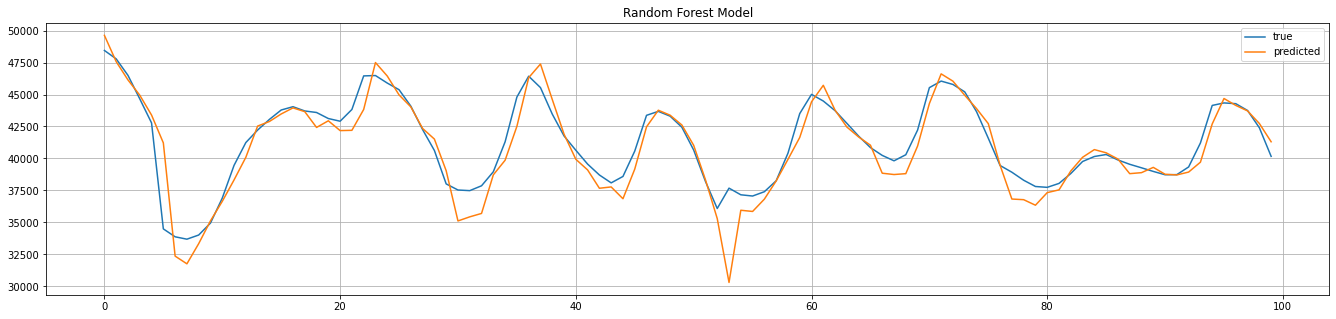

In [39]:
rmse_random,mae_random,mape_random,mse_random = performance_metrics(y_test,random_fst_prediction)
print('RSME :',rmse_random)
print('MAE :',mae_random)
print('MAPE :',mape_random)
print('MSE :',mse_random)

result_visualization(y_test,random_fst_prediction,title='Random Forest Model')

### SVR

In [ ]:
%%time

parameters = {'C':[100,300,500,750,1000,2000,5000,10000],
             'gamma':['auto','scale'],
             'kernel':['rbf','linear','poly']}

svr_reg = GridSearchCV(SVR(), param_grid = parameters,scoring='neg_mean_absolute_percentage_error', verbose=1,
                      n_jobs=-1,cv=3)
svr_reg.fit(X_train,y_train)
print("best parameters found was :",svr_reg.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
best parameters found was : {'C': 10000, 'gamma': 'auto', 'kernel': 'rbf'}
Wall time: 1h 30min 3s


In [47]:
%%time
svr_model = SVR(C=10000,gamma='auto',kernel='rbf')
svr_model.fit(X_train,y_train)
svr_prediction = svr_model.predict(X_test)

Wall time: 5min 19s


RSME : 1975.5559893970185
MAE : 1684.8399608567206
MAPE : 10.912394194229691
MSE : 3902821.4672424328


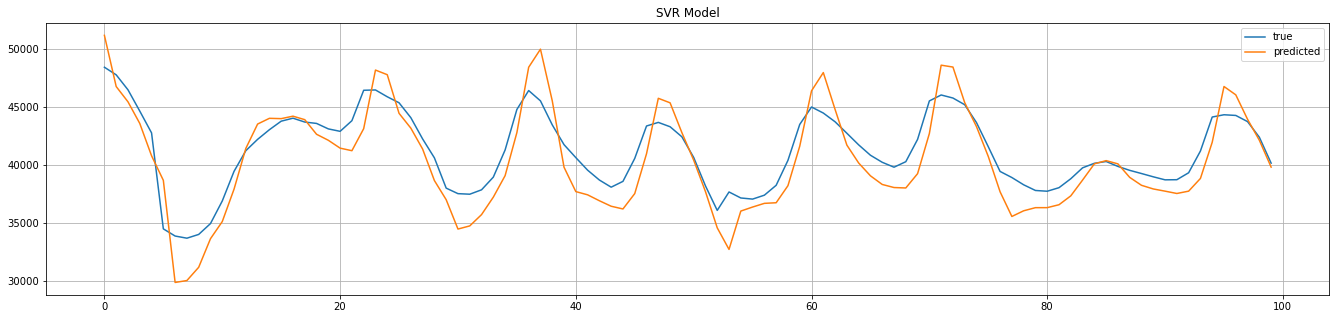

In [48]:
rmse_svr,mae_svr,mape_svr,mse_svr = performance_metrics(y_test,svr_prediction)
print('RSME :',rmse_svr)
print('MAE :',mae_svr)
print('MAPE :',mape_svr)
print('MSE :',mse_svr)

result_visualization(y_test,svr_prediction,title='SVR Model')

### Decision Tree Model

In [ ]:
%%time


parameters = {'max_depth': [2, 5, 15, 25, 50, 75, 100],
                                 'min_samples_split': [2, 3, 5, 7, 10],
                                 'min_samples_leaf': [1, 3, 5],
                                 'max_features': ['auto', 'sqrt', 'log2']}
dt_reg = GridSearchCV(DecisionTreeRegressor(),param_grid = parameters,scoring = 'neg_mean_absolute_percentage_error',
                     verbose=1,n_jobs=-1,cv=3)
dt_reg.fit(X_train,y_train)
print("best parameters found was :",dt_reg.best_params_)

Fitting 3 folds for each of 315 candidates, totalling 945 fits
best parameters found was : {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 10}
Wall time: 11min 36s


In [50]:
%%time
decision_tree_model = DecisionTreeRegressor(max_depth=15,max_features='auto',min_samples_leaf=5,
                                            min_samples_split =10,random_state=1)
decision_tree_model.fit(X_train,y_train)
decision_tree_prediction = decision_tree_model.predict(X_test)

Wall time: 854 ms


RSME : 1403.1463124873183
MAE : 949.0603144368902
MAPE : 9.655033773601826
MSE : 1968819.5742467588


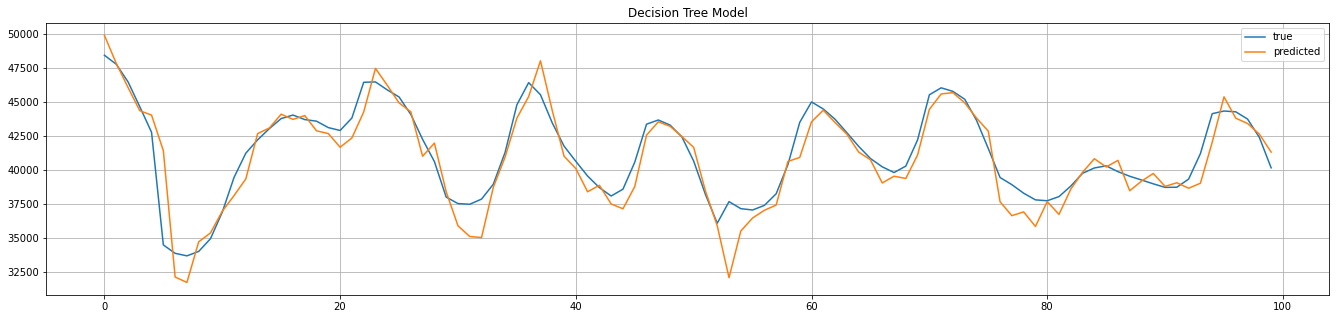

In [51]:
rmse_decision,mae_decision,mape_decision,mse_decision = performance_metrics(y_test,decision_tree_prediction)
print('RSME :',rmse_decision)
print('MAE :',mae_decision)
print('MAPE :',mape_decision)
print('MSE :',mse_decision)

result_visualization(y_test,decision_tree_prediction,title='Decision Tree Model')

### K_Nearest Neighbor Model

In [ ]:
%%time


parameters = {'n_neighbors':[5,10,20,30,40,50,60,70,80,90,100],
             'weights':['uniform','distance']}

knn_reg = GridSearchCV(KNeighborsRegressor(),param_grid = parameters,scoring = 'neg_mean_absolute_percentage_error',
                     verbose=1,n_jobs=-1,cv=3)
knn_reg.fit(X_train,y_train)
print("best parameters found was :",knn_reg.best_params_)

Fitting 3 folds for each of 22 candidates, totalling 66 fits
best parameters found was : {'n_neighbors': 10, 'weights': 'distance'}
Wall time: 3min 47s


In [14]:
%%time
knn_model = KNeighborsRegressor(n_neighbors=10,weights='distance')
knn_model.fit(X_train,y_train)
knn_prediction = knn_model.predict(X_test)

Wall time: 371 ms


RSME : 1514.6638709075676
MAE : 902.5028358841321
MAPE : 2.2667592042074736
MSE : 2294206.6418326967


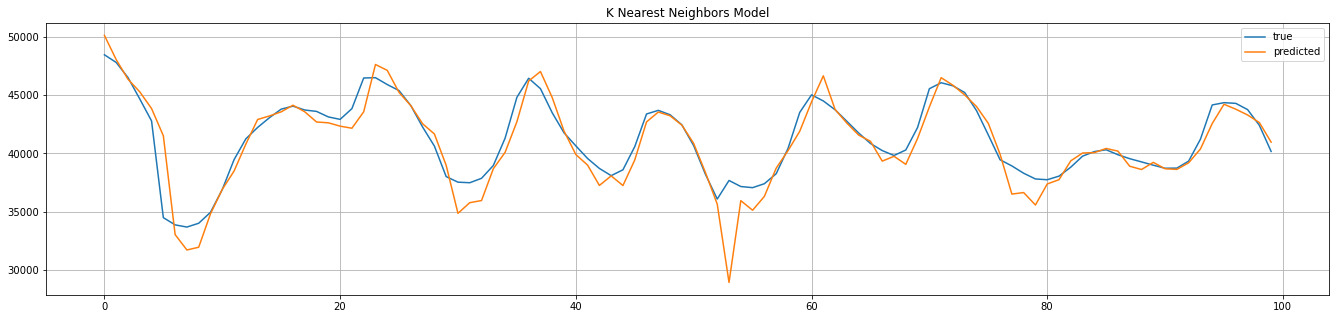

In [15]:
rmse_knn,mae_knn,mape_knn,mse_knn = performance_metrics(y_test,knn_prediction)
print('RSME :',rmse_knn)
print('MAE :',mae_knn)
print('MAPE :',mape_knn)
print('MSE :',mse_knn)

result_visualization(y_test,knn_prediction,title='K Nearest Neighbors Model')

## Deep Learning Model

In [12]:
#reshaping the training and test data to 3D tensor
X_tr = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_te = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#X_te = X_test.copy()
#reshaping the training and test data to 2D tensor
y_tr = y_train.reshape((y_train.shape[0],1))
y_te = y_test.reshape((y_test.shape[0],1))

print('Shape of X_train data after reshaping to 3D arrays :',X_tr.shape)
print('Shape of X_test data after reshaping to 3D arrays :',X_te.shape)
print('Rechecking the type of X_training data :',type(X_tr))
print('Rechecking the type of X_test data :',type(X_te))

print('Shape of y_train data after reshaping to 3D arrays :',y_tr.shape)
print('Shape of y_test data after reshaping to 3D arrays :',y_te.shape)
print('Rechecking the type of y_training data :',type(y_tr))
print('Rechecking the type of y_test data :',type(y_te))

Shape of X_train data after reshaping to 3D arrays : (145257, 4, 1)
Shape of X_test data after reshaping to 3D arrays : (100, 4, 1)
Rechecking the type of X_training data : <class 'numpy.ndarray'>
Rechecking the type of X_test data : <class 'numpy.ndarray'>
Shape of y_train data after reshaping to 3D arrays : (145257, 1)
Shape of y_test data after reshaping to 3D arrays : (100, 1)
Rechecking the type of y_training data : <class 'numpy.ndarray'>
Rechecking the type of y_test data : <class 'numpy.ndarray'>


### LSTM

In [21]:
tf.keras.backend.clear_session()  # For easy reset of notebook state
input_layer = Input(shape = (4,1),name = 'input_layer')
lstm_layer_1 = LSTM(500, return_sequences=True,activation='relu',name='lstm_layer_1')(input_layer)
dropout_layer_1 = Dropout(0.25,name='dropout_layer_1')(lstm_layer_1)
lstm_layer_2 = LSTM(600, return_sequences=True,activation='relu',name='lstm_layer_2')(dropout_layer_1)
#lstm_layer_3 = LSTM(500, return_sequences=True,activation='relu',name='lstm_layer_3')(lstm_layer_2)
dropout_layer_2 = Dropout(0.3,name='dropout_layer_2')(lstm_layer_2)
#dense_layer_1 = Dense(128,activation='relu',kernel_initializer="he_normal")(lstm_layer_2)
#dense_layer = Dense(256,activation='relu',kernel_initializer="he_normal")(dropout_layer_2)
output_layer = Dense(1,name='output_layer')(dropout_layer_2)

lstm_model=Model(inputs=input_layer,outputs=output_layer)
opt = Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
lstm_rmse = tf.keras.metrics.RootMeanSquaredError()
lstm_mape = tf.keras.metrics.MeanAbsolutePercentageError()
lstm_model.compile(optimizer=opt, loss='log_cosh',metrics=[lstm_rmse,lstm_mape])
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 4, 1)]            0         
                                                                 
 lstm_layer_1 (LSTM)         (None, 4, 500)            1004000   
                                                                 
 dropout_layer_1 (Dropout)   (None, 4, 500)            0         
                                                                 
 lstm_layer_2 (LSTM)         (None, 4, 600)            2642400   
                                                                 
 dropout_layer_2 (Dropout)   (None, 4, 600)            0         
                                                                 
 output_layer (Dense)        (None, 4, 1)              601       
                                                                 
Total params: 3,647,001
Trainable params: 3,647,001
Non-train

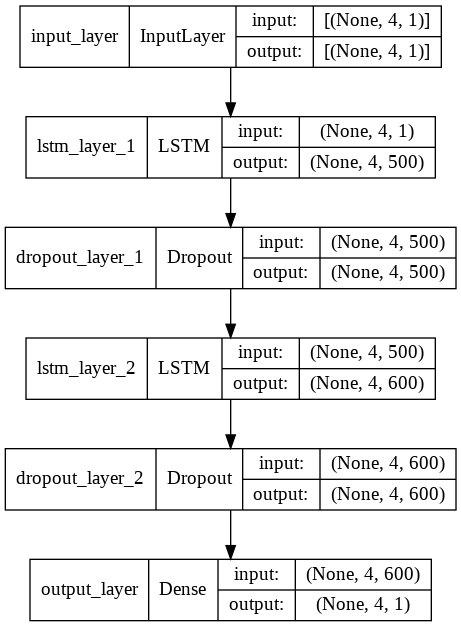

In [22]:
plot_model(lstm_model,show_shapes=True)

In [23]:
#callbacks
#check_pt = ModelCheckpoint('/content/gdrive/MyDrive/Case Study 1/lstm_model.hdf5', monitor = 'root_mean_squared_error')
lstm_earlystopping = EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=50,verbose=1,mode='min')

def Learning_Rate(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

lstm_lr_scheduler = LearningRateScheduler(Learning_Rate, verbose=1)

lstm_reduced_lr = ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=5,verbose=1,mode='min')

In [24]:
batch_size = 512*6
epochs = 500
#lstm_model.fit(X_tr,y_train,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[check_pt],validation_data=(X_te, y_test))
#lstm_model.fit(X_tr,y_tr,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[reduce_lr,lrschedule,lstm_earlystopping],validation_data=(X_te, y_te))
lstm_model.fit(X_tr,y_tr,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[lstm_reduced_lr,lstm_lr_scheduler,lstm_earlystopping])




Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
48/48 - 12s - loss: 4.0260 - root_mean_squared_error: 5.7836 - mean_absolute_percentage_error: 44.7311 - lr: 0.0010 - 12s/epoch - 240ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
48/48 - 9s - loss: 0.2360 - root_mean_squared_error: 0.7772 - mean_absolute_percentage_error: 5.6956 - lr: 0.0010 - 9s/epoch - 181ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
48/48 - 9s - loss: 0.1330 - root_mean_squared_error: 0.5511 - mean_absolute_percentage_error: 4.1612 - lr: 0.0010 - 9s/epoch - 183ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
48/48 - 9s - loss: 0.1240 - root_mean_squared_error: 0.5305 - mean_absolute_percentage_error: 3.9962 - lr: 0.0010 - 9s/epoch - 184ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.00098000004654

In [25]:
y_lstm_predictions = lstm_model.predict(X_te)
print(type(y_lstm_predictions))
print(y_lstm_predictions.shape)


<class 'numpy.ndarray'>
(100, 4, 1)


RSME : 1294.7864627922133
MAE : 938.5934375000014
MAPE : 2.325615743481773
MSE : 1676471.9842299717


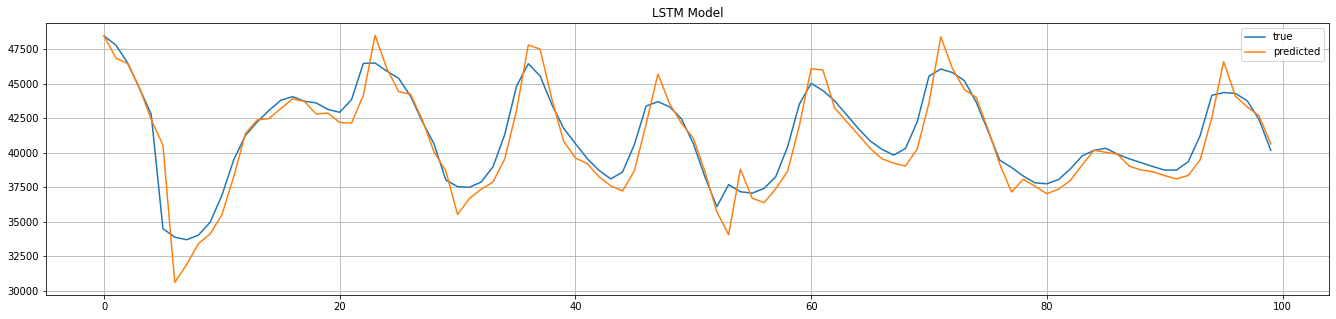

In [26]:
y_predicted = [x[3] for x in y_lstm_predictions]
rmse_lstm,mae_lstm,mape_lstm,mse_lstm = performance_metrics(y_te,y_predicted)
print('RSME :',rmse_lstm)
print('MAE :',mae_lstm)
print('MAPE :',mape_lstm)
print('MSE :',mse_lstm)

result_visualization(y_te,y_predicted,title='LSTM Model')

### Bidirectional LSTM Model

In [ ]:
tf.keras.backend.clear_session()  # For easy reset of notebook state
input_layer = Input(shape = (4,1),name = 'input_layer')
lstm_layer_1 = Bidirectional(LSTM(600, return_sequences=True,activation='relu'),name='lstm_layer_1')(input_layer)
dropout_layer_1 = Dropout(0.25,name='dropout_layer_1')(lstm_layer_1)
#lstm_layer_2 = Bidirectional(LSTM(200, return_sequences=True,activation='relu'),name='lstm_layer_2')(dropout_layer_1)
#dropout_layer_2 = Dropout(0.15,name='dropout_layer_2')(lstm_layer_2)
dense_layer_1 = Dense(128,activation='relu',kernel_initializer="he_normal")(dropout_layer_1)
dense_layer = Dense(128,activation='relu',kernel_initializer="he_normal")(dense_layer_1)
output_layer = Dense(1,name='output_layer')(dense_layer)

bi_lstm_model=Model(inputs=input_layer,outputs=output_layer)
opt = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
lstm_rmse = tf.keras.metrics.RootMeanSquaredError()
lstm_mape = tf.keras.metrics.MeanAbsolutePercentageError()
bi_lstm_model.compile(optimizer=opt, loss='log_cosh',metrics=[lstm_rmse,lstm_mape])
bi_lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 4, 1)]            0         
                                                                 
 lstm_layer_1 (Bidirectional  (None, 4, 1200)          2889600   
 )                                                               
                                                                 
 dropout_layer_1 (Dropout)   (None, 4, 1200)           0         
                                                                 
 dense (Dense)               (None, 4, 128)            153728    
                                                                 
 dense_1 (Dense)             (None, 4, 128)            16512     
                                                                 
 output_layer (Dense)        (None, 4, 1)              129       
                                                             

In [ ]:
#callbacks
#check_pt = ModelCheckpoint('/content/gdrive/MyDrive/Case Study 1/lstm_model.hdf5', monitor = 'root_mean_squared_error')
lstm_earlystopping = EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=50,verbose=1,mode='min')

def Learning_Rate(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

lstm_lr_scheduler = LearningRateScheduler(Learning_Rate, verbose=1)

lstm_reduced_lr = ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=5,verbose=1,mode='min')

In [ ]:
batch_size = 512*4
epochs = 100
#lstm_model.fit(X_tr,y_train,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[check_pt],validation_data=(X_te, y_test))
#lstm_model.fit(X_tr,y_tr,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[reduce_lr,lrschedule,lstm_earlystopping],validation_data=(X_te, y_te))
bi_lstm_model.fit(X_tr,y_tr,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[lstm_reduced_lr,lstm_lr_scheduler,lstm_earlystopping])




Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
71/71 - 9s - loss: 0.0494 - root_mean_squared_error: 0.3218 - mean_absolute_percentage_error: 2.4758 - lr: 0.0010 - 9s/epoch - 130ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
71/71 - 9s - loss: 0.0449 - root_mean_squared_error: 0.3064 - mean_absolute_percentage_error: 2.3567 - lr: 0.0010 - 9s/epoch - 128ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
71/71 - 9s - loss: 0.0413 - root_mean_squared_error: 0.2931 - mean_absolute_percentage_error: 2.2556 - lr: 0.0010 - 9s/epoch - 129ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
71/71 - 9s - loss: 0.0383 - root_mean_squared_error: 0.2820 - mean_absolute_percentage_error: 2.1715 - lr: 0.0010 - 9s/epoch - 128ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.00098000004654750

In [ ]:
y_bi_lstm_predictions = bi_lstm_model.predict(X_te)
print(type(y_bi_lstm_predictions))
print(y_bi_lstm_predictions.shape)


<class 'numpy.ndarray'>
(100, 4, 1)


RSME : 1756.872158178464
MAE : 1282.5551953125002
MAPE : 3.1232587691357514
MSE : 3086599.780182653


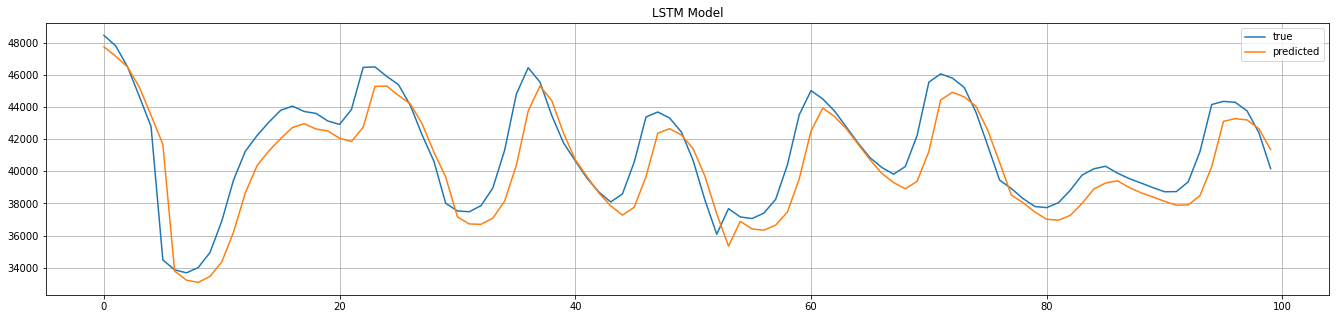

In [ ]:
y_predicted_bi = [x[3] for x in y_bi_lstm_predictions]
rmse_lstm,mae_lstm,mape_lstm,mse_lstm = performance_metrics(y_te,y_predicted_bi)
print('RSME :',rmse_lstm)
print('MAE :',mae_lstm)
print('MAPE :',mape_lstm)
print('MSE :',mse_lstm)

result_visualization(y_te,y_predicted_bi,title='LSTM Model')

In [3]:
## Observations/Results

In [5]:
result = PrettyTable()
result.field_names = ["Model","RMSE","MAE","MAPE","MSE"]
result.add_row(["Dummy Regressor",3322.887,2808.981,6.99,11041582.697])
result.add_row(["SVR Model",1975.555,1684.839,10.912,3902821.467])
result.add_row(["LightGBM",1303.995,848.455,9.74,1700405.324])
result.add_row(["SGD Linear Regression",1291.925,872.974,9.50,1669070.223])
result.add_row(["Random Forest Model",1403.481,877.008,9.741,1969760.457])
result.add_row(["Decision Tree Model",1403.146,949.060,9.665,1968819.574])
result.add_row(["KNN Model",1514.603,902.502,2.226,2294206.641])
result.add_row(["LSTM Model",1294.786,938.593,2.325,1676471.984])
result.add_row(["Bidirectional LSTM Model",1756.872,1282.555,3.123,3086599.780])
print(result)

+--------------------------+----------+----------+--------+--------------+
|          Model           |   RMSE   |   MAE    |  MAPE  |     MSE      |
+--------------------------+----------+----------+--------+--------------+
|     Dummy Regressor      | 3322.887 | 2808.981 |  6.99  | 11041582.697 |
|        SVR Model         | 1975.555 | 1684.839 | 10.912 | 3902821.467  |
|         LightGBM         | 1303.995 | 848.455  |  9.74  | 1700405.324  |
|  SGD Linear Regression   | 1291.925 | 872.974  |  9.5   | 1669070.223  |
|   Random Forest Model    | 1403.481 | 877.008  | 9.741  | 1969760.457  |
|   Decision Tree Model    | 1403.146 |  949.06  | 9.665  | 1968819.574  |
|        KNN Model         | 1514.603 | 902.502  | 2.226  | 2294206.641  |
|        LSTM Model        | 1294.786 | 938.593  | 2.325  | 1676471.984  |
| Bidirectional LSTM Model | 1756.872 | 1282.555 | 3.123  |  3086599.78  |
+--------------------------+----------+----------+--------+--------------+


We can see from the results that models doesnot perform well of this new dataset ,the RMSE >1000 for all model while in part one of the modelling where the dataset obtained from feature engineering ,the modelling on that dataset performs very well especially Random Forest and SARIMA model.<br>
So we will select Random Forest Model from part-1 of modellinh because it has the lowest RMSE.